# LSTM Model

In [10]:
import pandas as pd 
from sklearn.model_selection  import train_test_split
import numpy as np 
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas.plotting import lag_plot
from sklearn import metrics
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load and PreProcess 

In [11]:
data = pd.read_csv('data/PMS_data.csv',nrows=100000)

In [12]:
data.head()

,Flow,Occupy,Speed
0,133.0,0.0603,65.8
1,210.0,0.0589,69.6
2,124.0,0.0358,65.8
3,145.0,0.0416,69.6
4,206.0,0.0493,69.4


In [4]:
new_set = data[['Flow','Occupy']].copy()

In [5]:
new_set.head()

,Flow,Occupy
0,133.0,0.0603
1,210.0,0.0589
2,124.0,0.0358
3,145.0,0.0416
4,206.0,0.0493


In [95]:
new_set['Flow'] = np.around(new_set['Flow'])
new_set.head()

,Flow,Occupy
0,133.0,0.0603
1,210.0,0.0589
2,124.0,0.0358
3,145.0,0.0416
4,206.0,0.0493


In [96]:
new_set_plot = new_set.values

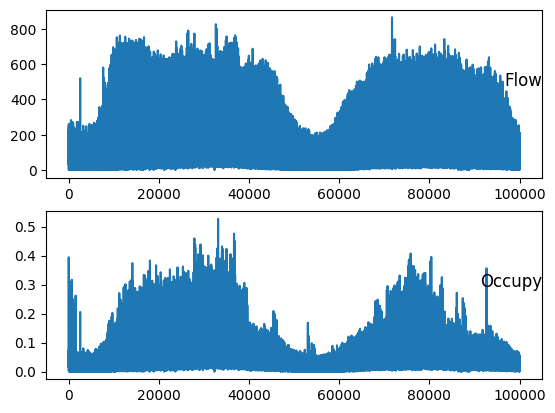

In [97]:
groups = [0, 1]
i = 1
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(new_set_plot[:, group])
    plt.title(new_set.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [98]:
from sklearn.preprocessing import StandardScaler


In [99]:
scaler = StandardScaler()

In [100]:
new_set

,Flow,Occupy
0,133.0,0.0603
1,210.0,0.0589
2,124.0,0.0358
3,145.0,0.0416
4,206.0,0.0493
...,...,...
99995,127.0,0.0326
99996,127.0,0.0227
99997,124.0,0.0402
99998,99.0,0.0248


In [101]:
x = new_set.Occupy.values

y = new_set.Flow.values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25)

In [102]:
x_train = scaler.fit_transform(x_train.reshape(-1,1))
y_train = scaler.fit_transform(y_train.reshape(-1,1))
x_test = scaler.fit_transform(x_test.reshape(-1,1))
y_test = scaler.fit_transform(y_test.reshape(-1,1))

In [103]:
#x_train = x_train.reshape(-1,1)
x_train.shape

(75000, 1)

In [104]:
#x_test = x_test.reshape(-1,1)
x_test.shape

(25000, 1)

In [128]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM ,Dense , Dropout,Activation,Lambda, Bidirectional
import tensorflow as tf

model = Sequential()
model.add(LSTM(50,activation="relu",return_sequences=True,input_shape=(x_train.shape[0],x_train.shape[1])))
model.add(LSTM(50,return_sequences = False,activation="relu"))
model.add(Dense(50))
model.add(Dropout(0.2))
model.add(Dense(1))


In [129]:
model = Sequential([
  Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
  Bidirectional(LSTM(128,activation="relu", return_sequences=True)),
  LSTM(64,activation="relu", return_sequences=True),
  LSTM(128,activation="relu", return_sequences=False),
  Dense(50),
  Dropout(0.5),
  Dense(1),
  Lambda(lambda x: x*20)
])

In [130]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 256)        133120    
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          82176     
                                                                 
 lstm_2 (LSTM)               (None, 128)               98816     
                                                                 
 dense (Dense)               (None, 50)                6450      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                        

In [131]:
loss_fn= tf.losses.Huber()
tf.keras.backend.clear_session()
model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam())
history = model.fit(x_train, y_train, epochs=5, batch_size=50, validation_data=(x_test, y_test), shuffle=False)
     

Epoch 1/5
1500/1500 [==============================] - 14s 8ms/step - loss: 0.4110 - val_loss: 0.3732
Epoch 2/5
1500/1500 [==============================] - 11s 8ms/step - loss: 0.3985 - val_loss: 0.3740
Epoch 3/5
1500/1500 [==============================] - 12s 8ms/step - loss: 0.3962 - val_loss: 0.3716
Epoch 4/5
1500/1500 [==============================] - 11s 8ms/step - loss: 0.3954 - val_loss: 0.3735
Epoch 5/5
1500/1500 [==============================] - 11s 8ms/step - loss: 0.3954 - val_loss: 0.3713


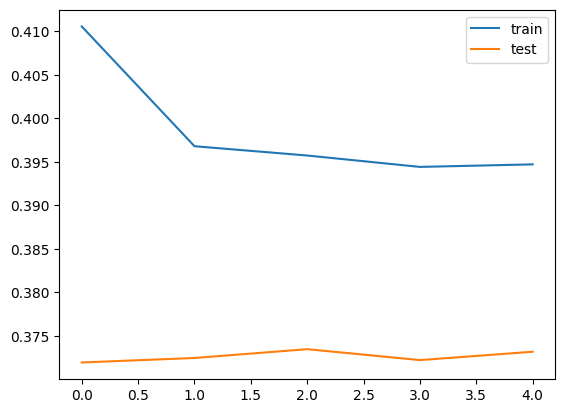

In [108]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [110]:
# make a prediction
y_pred = model.predict(x_test)


782/782 [==============================] - 3s 3ms/step


In [111]:
y_pred.shape

(25000, 1)

In [112]:
y_prednormal=scaler.inverse_transform(y_pred)
y_testnormal=scaler.inverse_transform(y_test)

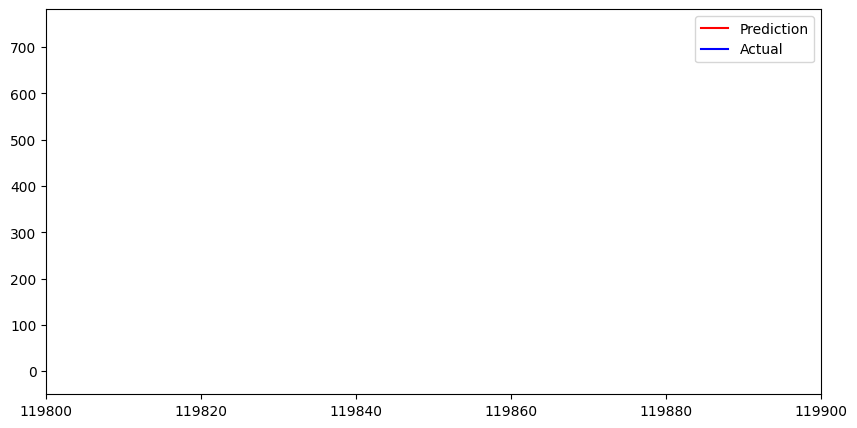

In [113]:
plt.figure(figsize=(10,5))
plt.plot(y_prednormal,color = 'red',label = 'Prediction')
plt.plot(y_testnormal,color = 'blue',label = 'Actual')
plt.legend()
plt.xlim(119800,119900)
plt.show()

In [118]:
r2s = metrics.r2_score(y_true=y_testnormal,y_pred=y_prednormal)
r2s

0.6268272490886585

In [115]:
rmse = sqrt(metrics.mean_squared_error(y_testnormal, y_prednormal))
rmse

87.16013067695799

In [116]:
mae = metrics.mean_absolute_error(y_true=y_testnormal,y_pred=y_prednormal)
mae

64.882292634691

In [117]:
mse = metrics.mean_squared_error(y_true=y_testnormal,y_pred=y_prednormal)
mse

7596.8883796243945

# chatGPT 1 features

In [133]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

# Load the data
data = new_set[["Flow"]]
#data = data[['traffic_volume']]

# Normalize the data
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# Split the data into training and testing sets
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train_data, test_data = data[0:train_size,:], data[train_size:len(data),:]

# Create sequences of data
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data)-seq_length-1):
        x.append(data[i:(i+seq_length), 0])
        y.append(data[i+seq_length, 0])
    return np.array(x), np.array(y)

seq_length = 30
trainX, trainY = create_sequences(train_data, seq_length)
testX, testY = create_sequences(test_data, seq_length)

# Reshape the data for the LSTM model
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(seq_length, 1)),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
history = model.fit(trainX, trainY, epochs=100, batch_size=64, validation_data=(testX, testY))

# Make predictions on the test data
testPredict = model.predict(testX)

# Inverse transform the predictions and actual values
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Calculate root mean squared error
rmse = np.sqrt(np.mean((testPredict - testY) ** 2))
print('Test RMSE: %.2f' % rmse)


Epoch 1/100
1250/1250 [==============================] - 26s 20ms/step - loss: 0.0170 - val_loss: 0.0149
Epoch 2/100
1250/1250 [==============================] - 25s 20ms/step - loss: 0.0158 - val_loss: 0.0137
Epoch 3/100
1250/1250 [==============================] - 26s 21ms/step - loss: 0.0138 - val_loss: 0.0123
Epoch 4/100
1250/1250 [==============================] - 25s 20ms/step - loss: 0.0114 - val_loss: 0.0105
Epoch 5/100
1250/1250 [==============================] - 26s 20ms/step - loss: 0.0098 - val_loss: 0.0095
Epoch 6/100
1250/1250 [==============================] - 26s 20ms/step - loss: 0.0083 - val_loss: 0.0080
Epoch 7/100
1250/1250 [==============================] - 25s 20ms/step - loss: 0.0072 - val_loss: 0.0079
Epoch 8/100
1250/1250 [==============================] - 25s 20ms/step - loss: 0.0063 - val_loss: 0.0069
Epoch 9/100
1250/1250 [==============================] - 25s 20ms/step - loss: 0.0057 - val_loss: 0.0062
Epoch 10/100
1250/1250 [==============================]

1250/1250 [==============================] - 28s 23ms/step - loss: 0.0010 - val_loss: 0.0024
Epoch 79/100
1250/1250 [==============================] - 29s 23ms/step - loss: 0.0010 - val_loss: 0.0024
Epoch 80/100
1250/1250 [==============================] - 28s 23ms/step - loss: 0.0010 - val_loss: 0.0024
Epoch 81/100
1250/1250 [==============================] - 28s 23ms/step - loss: 0.0010 - val_loss: 0.0025
Epoch 82/100
1250/1250 [==============================] - 28s 23ms/step - loss: 0.0010 - val_loss: 0.0024
Epoch 83/100
1250/1250 [==============================] - 28s 23ms/step - loss: 9.9721e-04 - val_loss: 0.0026
Epoch 84/100
1250/1250 [==============================] - 28s 23ms/step - loss: 9.9703e-04 - val_loss: 0.0024
Epoch 85/100
1250/1250 [==============================] - 28s 23ms/step - loss: 9.9584e-04 - val_loss: 0.0024
Epoch 86/100
1250/1250 [==============================] - 29s 23ms/step - loss: 9.7950e-04 - val_loss: 0.0024
Epoch 87/100
1250/1250 [===================

# chatGPT 2 features

In [38]:
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('data/PMS_data.csv',nrows=100000)

# Extract the features you want to use
data = data[['Flow', 'Occupy']]

# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Split the data into training and testing sets
train_size = int(len(data_scaled) * 0.8)
train_data, test_data = data_scaled[0:train_size], data_scaled[train_size:]
print(train_data.shape[1])

def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data)-seq_length-1):
        # Extract two features (traffic volume and temperature)
        feature1 = data[i:(i+seq_length), 0]
        feature2 = data[i:(i+seq_length), 1]
        x.append(np.column_stack((feature1, feature2)))
        y.append(data[i+seq_length, 0])
    return np.array(x), np.array(y)
seq_length = 30
trainX, trainY = create_sequences(train_data, seq_length)
testX, testY = create_sequences(test_data, seq_length)

# Define the LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(loss='mse', optimizer='adam')

# Fit the model
history = model.fit(trainX, trainY, epochs=50, batch_size=72, validation_data=(testX, testY), verbose=2, shuffle=False)


2
Epoch 1/50


KeyboardInterrupt: 

In [61]:
# Make predictions on the test data
predictions = model.predict(testX)
predictions = np.concatenate((predictions, testY.reshape(-1,1)), axis=1)
predictions = scaler.inverse_transform(predictions)



625/625 [==============================] - 5s 7ms/step
(100000, 2)


ValueError: Found input variables with inconsistent numbers of samples: [99999, 19969]

(19969,)
Test RMSE: 116.79


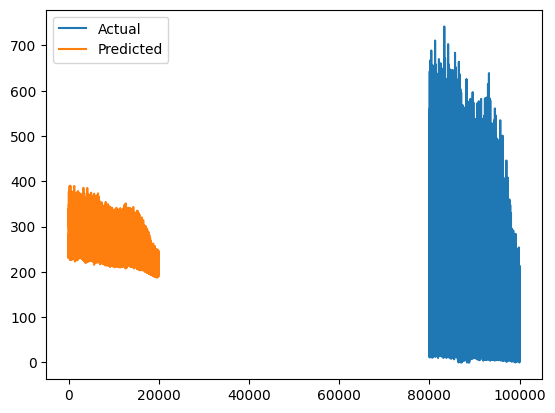

In [71]:
# Calculate root mean squared error
print(data[data.shape[0]-len(predictions):]["Flow"].shape)
rmse = np.sqrt(mean_squared_error(data[data.shape[0]-len(predictions):]["Flow"], predictions[:,0]))
print('Test RMSE: %.2f' % rmse)

# Plot the predictions and actual values
plt.plot(data[data.shape[0]-len(predictions):]["Flow"], label='Actual')
plt.plot(predictions[:, 0], label='Predicted')
plt.legend()
plt.show()

In [143]:
testYshape=testY.reshape(19969,1)
print(testY.shape)
print(testYshape.shape)
print(testPredict.shape)
r2s = metrics.r2_score(y_true=testYshape,y_pred=testPredict)
r2s

(1, 19969)
(19969, 1)
(19969, 1)


0.8769362474481817

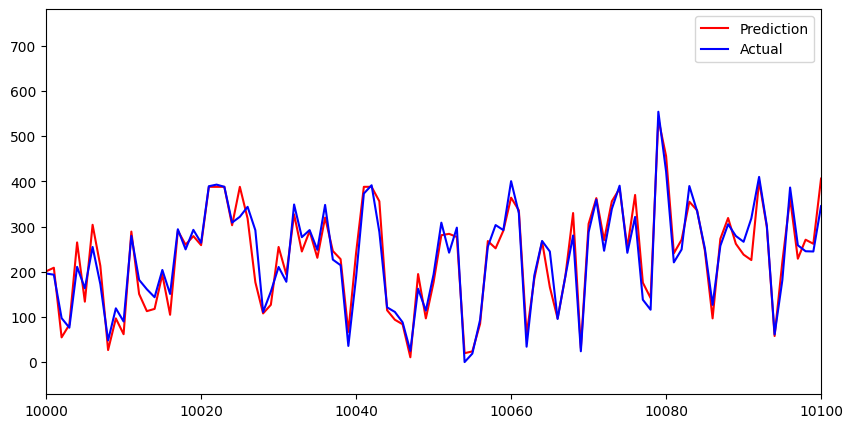

In [147]:
plt.figure(figsize=(10,5))
plt.plot(testYshape,color = 'red',label = 'Prediction')
plt.plot(testPredict,color = 'blue',label = 'Actual')
plt.legend()
plt.xlim(10000,10100)
plt.show()